In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 
import pandas as pd
import numpy as np

c:\Users\abdfa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Loading Data**

In [2]:
sent_df = pd.read_csv('sentiment_analysis.csv')
sent_df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [3]:
X = list(sent_df['text'])
y = np.array(sent_df['sentiment'].replace(['negative','neutral','positive'], [0,1,2]))

C:\Users\abdfa\AppData\Local\Temp\ipykernel_18840\187138171.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = np.array(sent_df['sentiment'].replace(['negative','neutral','positive'], [0,1,2]))


## **Creating the Model**

In [4]:
model_name = "MarieAngeA13/Sentiment-Analysis-BERT"

In [5]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# Example dataset
sentences = ["I hate programming.", "Hugging Face is a great library.", "Quantization is a cool technique."]

# Tokenize the sentences
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
# Perform inference
with torch.no_grad():

    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# 0 -> Negative, 1 -> Neutral, 2 -> Positive

print(predictions)

tensor([0, 2, 2], device='cuda:0')


c:\Users\abdfa\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


## **Evaluating the Initial Model**

In [7]:
def eval(X,y,model,device):
    y_pred = predict(X,model,device)
    return (y_pred.to('cpu') == torch.tensor(y)).sum().item() / len(y)

In [8]:
def predict(X,model,device):
    inputs = tokenizer(X, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions

In [9]:
original_model_acc = eval(X,y,model,device)
print(f"Original model accuracy: {original_model_acc:.3f}")

Original model accuracy: 0.824


In [10]:
original_model_footprint = model.get_memory_footprint()
print(f"Original model footprint: {original_model_footprint}")

Original model footprint: 437946380


## **Quantatizing the Model**

In [11]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")
quant_model = AutoModelForSequenceClassification.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT", quantization_config=bnb_config)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [12]:
quant_model_acc = eval(X,y,quant_model,'cpu')
print(f"Quantized model accuracy: {quant_model_acc:.3f}")

Quantized model accuracy: 0.830


In [13]:
quant_model_footprint = quant_model.get_memory_footprint()
print(f"Quantized model footprint: {quant_model_footprint}")

Quantized model footprint: 90690566


## **Plot the difference between the original and quantatized model**

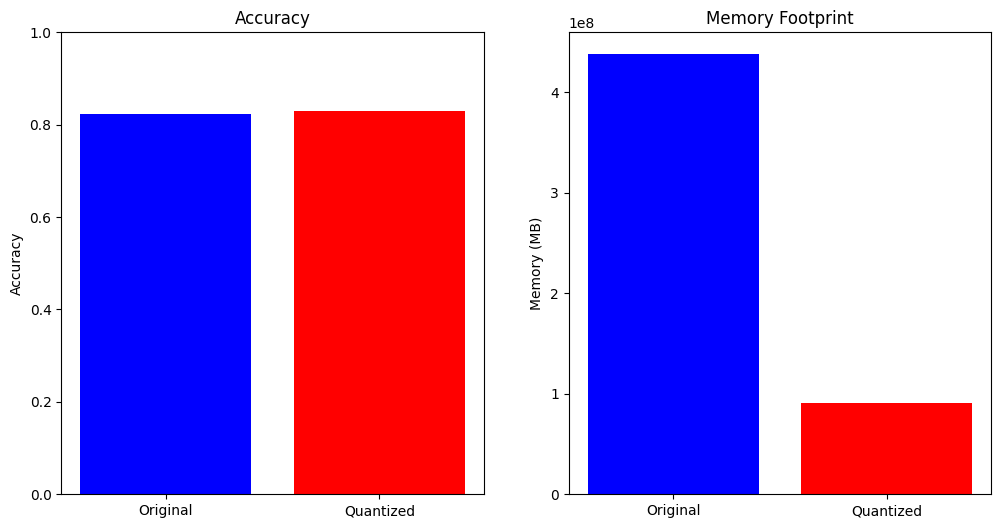

In [23]:
import matplotlib.pyplot as plt

# Plot the difference in accuracy and memory footprint
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(['Original', 'Quantized'], [original_model_acc, quant_model_acc], color=['blue', 'red'])
ax[0].set_title('Accuracy')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Accuracy')
ax[1].bar(['Original', 'Quantized'], [original_model_footprint, quant_model_footprint], color=['blue', 'red'])
ax[1].set_title('Memory Footprint')
ax[1].set_ylabel('Memory (MB)')
plt.show()

